# Comparison between a CAV and VAV System under Summer Part-Load Operation
---

In this notebook a single-zone constant air volume (CAV) and variable air volume (VAV) air conditioning system at part-load operation are analyzed with the package `hvac.air_conditioning`. The example is taken from the book **Heating and Cooling of Buildings** by *T. Agami Reddy, Jan F. Kreider, Peter S. Curtiss and Ari Rabl* (3th Edition, 2017), Chapter 19.

In [1]:
from deps import load_packages
load_packages()

In [2]:
import jupyter_addons as ja
ja.set_css()

Under part-load operation the space thermostat keeps the dry-bulb temperature in the space constant by modulating the supply air temperature. The air humidity of the space will depend on the latent heat load of the space and the kind of AC system (CAV or VAV). 

## CAV System at Part Load

*We consider the same single-zone CAV system that was designed under summer peak-load condition in a previous notebook. This example will serve to illustrate how the CAV system needs to be operated under part-load condition so as to maintain satisfactory indoor space conditions. We will determine the cooling coil loads as well as the reheat energy required in this case. We assume the same zone and cooling coil outlet temperatures and the same amount of ventilation air. The outdoor air conditions are 80°F and 60% RH, while the space cooling load is now 70,000 Btu/h with SHR = 0.7.*

In [3]:
from hvac import Quantity
from hvac.fluids import HumidAir
from hvac.air_conditioning import AirConditioningProcess, AdiabaticMixing, AirStream
from hvac.charts import PsychrometricChart, StatePoint

In [4]:
Q_ = Quantity

### 0. Known Data

**Zone**

Zone air db-temperature:

In [5]:
T_zone = Q_(78, 'degF')

Space load:

In [6]:
Q_zone = Q_(70_000, 'Btu / hr')
SHR_zone = Q_(0.7, 'frac')

**Outdoor air ventilation**

In [7]:
outdoor_air = HumidAir(Tdb=Q_(80, 'degF'), RH=Q_(60, 'pct'))

In [8]:
V_vent = Q_(1000, 'ft ** 3 / min')
m_vent = outdoor_air.rho * V_vent

**Mass flow rate of supply air**<br>
Under part-load condition the space thermostat keeps the db-temperature in the space constant by modulating the supply air temperature, while the supply airflow rate remains fixed (hence the term constant air volume or CAV). 

In [9]:
m_supply = Q_(17_140, 'lb / hr')

**Condition of air leaving the cooling coil**<br>
The condition of the air leaving the cooling coil remains unchanged in order to provide the dehumidification necessary for occupant comfort.

In [10]:
cooled_air = HumidAir(Tdb=Q_(58, 'degF'), RH=Q_(0.8, 'frac'))

### 1. Determine Supply Air Condition and Relative Humidity of Zone Air

**The mass flow rate of supply air is known as it remains fixed in a CAV system.** The required supply air temperature can the determined from the sensible heat load of the zone. As the humidity ratio of the air through the reheat coil remains constant, the supply air to the zone will have the same humidity ratio as the cooled air at the cooling coil outlet. Knowing the required supply air condition to compensate for the sensible heat load of the space, the resulting air humidity in the space follows from the latent heat balance of the space.

In [11]:
zone = AirConditioningProcess(
    W_ai=cooled_air.W,
    T_ao=T_zone,
    m_da=m_supply,
    Q=Q_zone,
    SHR=SHR_zone
)
supply_air = zone.air_in
zone_air = zone.air_out

ja.display_list([
    f"supply air at part-load: <b>{supply_air.Tdb.to('degF'):~P.1f}, {supply_air.RH.to('pct'):~P.0f}</b>",
    f"zone air at part-load: <b>{zone_air.Tdb.to('degF'):~P.1f}, {zone_air.RH.to('pct'):~P.0f}</b>"
])

### 2. Determine Mixed Air Condition at Cooling Coil Inlet

In [12]:
mixing_chamber = AdiabaticMixing(
    in1=AirStream(state=outdoor_air, m_da=m_vent),
    in2=AirStream(state=zone_air, m_da=m_supply-m_vent),
    out=AirStream(m_da=m_supply)
)
mixed_air = mixing_chamber.stream_out.state

ja.display_list([
    f"mixed air at part-load: <b>{mixed_air.Tdb.to('degF'):~P.1f}, {mixed_air.RH.to('pct'):~P.0f}</b>"
])

### 3. Determine Cooling Coil Load

In [13]:
cooling_coil = AirConditioningProcess(
    air_in=mixed_air,
    air_out=cooled_air,
    m_da=m_supply
)

ja.display_list([
    f"cooling coil load at part-load: <b>{cooling_coil.Q.to('Btu / hr'):~P.0f}</b>"
])

### 4. Determine Reheat Coil Load

In a CAV system with fixed supply air mass flow rate and fixed air condition at the cooling coil exit (actually needed in a multizone system), reheating the supply air at the entrance of the zone is necessary to get at the required supply air temperature to meet the sensible heat load of the zone. The simultaneous operation of the cooling coil and reheat coil is called "coil bucking".

In [14]:
reheat_coil = AirConditioningProcess(
    air_in=cooled_air,
    air_out=supply_air,
    m_da=m_supply
)

ja.display_list([
    f"reheat coil load at part-load: <b>{reheat_coil.Q.to('Btu / hr'):~P.0f}</b>"
])

### Psychrometric Chart

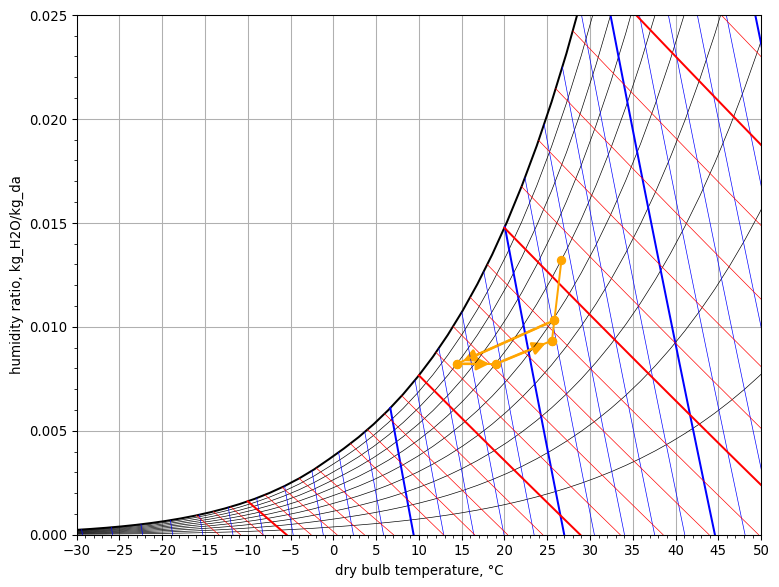

In [15]:
psych_chart = PsychrometricChart(fig_size=(8, 6))
psych_chart.plot_process(
    name='mixing_chamber',
    start_point=StatePoint(outdoor_air.Tdb, outdoor_air.W),
    end_point=StatePoint(zone_air.Tdb, zone_air.W),
    mix_point=StatePoint(mixed_air.Tdb, mixed_air.W)
)
psych_chart.plot_process(
    name='cooling_coil',
    start_point=StatePoint(mixed_air.Tdb, mixed_air.W),
    end_point=StatePoint(cooled_air.Tdb, cooled_air.W)
)
psych_chart.plot_process(
    name='reheat_coil',
    start_point=StatePoint(cooled_air.Tdb, cooled_air.W),
    end_point=StatePoint(supply_air.Tdb, supply_air.W)
)
psych_chart.plot_process(
    name='zone',
    start_point=StatePoint(supply_air.Tdb, supply_air.W),
    end_point=StatePoint(zone_air.Tdb, zone_air.W)
)
psych_chart.show()

## VAV System at part-load

*Consider the same conditions as for the CAV system above. We will solve the same problem assuming VAV system operation.*

### 0. Known data

Same as above.

### 1. Determine the Supply Air Mass Flow Rate and Verify Indoor Comfort

**The supply air temperature is equal to the set temperature of the cooling coil, i.e. at the cooling coil exit.** Also the humidity ratio between the cooling coil exit and the supply air entrance to the space remains unchanged. The required supply air mass flow rate can be determined from the sensible heat balance of the space. The humidity of the zone air then follows from the latent heat balance of the space.

In [16]:
supply_air = cooled_air

zone = AirConditioningProcess(
    air_in=supply_air,
    T_ao=T_zone,
    Q=Q_zone,
    SHR=SHR_zone
)
m_supply = zone.m_da
zone_air = zone.air_out

ja.display_list([
    f"supply air mass flow rate at part-load: <b>{m_supply.to('lb / hr'):~P.0f}</b>",
    f"zone air at part-load: <b>{zone_air.Tdb.to('degF'):~P.1f}, {zone_air.RH.to('pct'):~P.0f}</b>"
])

### 2. Determine Mixed Air Condition at Cooling Coil Inlet

In [17]:
mixing_chamber = AdiabaticMixing(
    in1=AirStream(state=outdoor_air, m_da=m_vent),
    in2=AirStream(state=zone_air, m_da=m_supply-m_vent),
    out=AirStream(m_da=m_supply)
)
mixed_air = mixing_chamber.stream_out.state

ja.display_list([
    f"mixed air at part-load: <b>{mixed_air.Tdb.to('degF'):~P.1f}, {mixed_air.RH.to('pct'):~P.0f}</b>"
])

### 3. Determine Cooling Coil Load

In [18]:
cooling_coil = AirConditioningProcess(
    air_in=mixed_air,
    air_out=cooled_air,
    m_da=m_supply
)

ja.display_list([
    f"cooling coil load at part-load: <b>{cooling_coil.Q.to('Btu / hr'):~P.0f}</b>"
])

### Psychrometric Chart

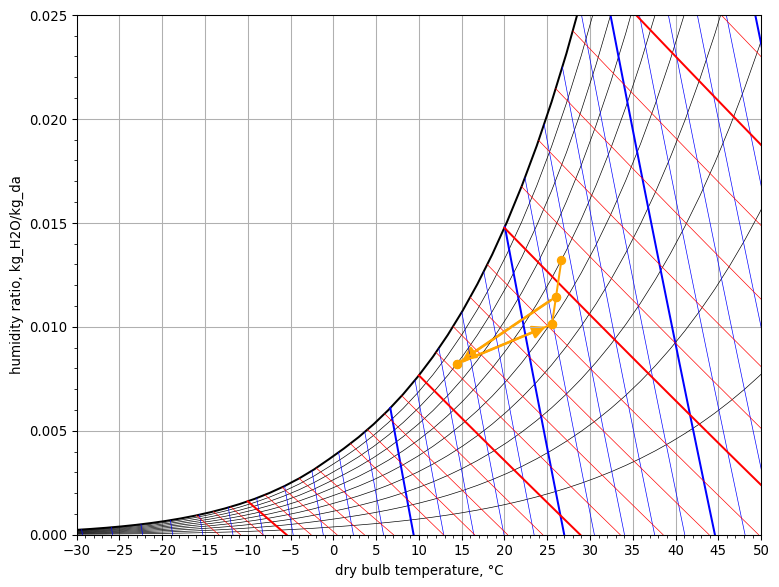

In [19]:
psych_chart = PsychrometricChart(fig_size=(8, 6))
psych_chart.plot_process(
    name='mixing_chamber',
    start_point=StatePoint(outdoor_air.Tdb, outdoor_air.W),
    end_point=StatePoint(zone_air.Tdb, zone_air.W),
    mix_point=StatePoint(mixed_air.Tdb, mixed_air.W)
)
psych_chart.plot_process(
    name='cooling_coil',
    start_point=StatePoint(mixed_air.Tdb, mixed_air.W),
    end_point=StatePoint(cooled_air.Tdb, cooled_air.W)
)
psych_chart.plot_process(
    name='zone',
    start_point=StatePoint(supply_air.Tdb, supply_air.W),
    end_point=StatePoint(zone_air.Tdb, zone_air.W)
)
psych_chart.show()